## Setup

Import necessary modules and dependencies.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from tensorflow import keras
from tensorflow.keras.models import Sequential


## Import the dataset

In [2]:
data_dir = 'Dataset/'

### Check basic statistics about the dataset.

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Languages:', commands)

Languages: ['Kannada' 'Tamil' 'Telugu']


### Extract the audio files into a list and shuffle it.

In [4]:
filenames=[]   # will store the file names
# import required module
import os
# assign directory
directory = 'Dataset/Kannada/'

# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        filenames.append(f)
        
directory = 'Dataset/Tamil/'

# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        filenames.append(f)

directory = 'Dataset/Telugu/'

# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        filenames.append(f)

In [5]:
filenames[:10]

['Dataset/Kannada/knm_00180_00011382081.wav',
 'Dataset/Kannada/knm_00180_00012816557.wav',
 'Dataset/Kannada/knm_00180_00028931935.wav',
 'Dataset/Kannada/knm_00180_00031068402.wav',
 'Dataset/Kannada/knm_00180_00042410675.wav',
 'Dataset/Kannada/knm_00180_00079643205.wav',
 'Dataset/Kannada/knm_00180_00130644026.wav',
 'Dataset/Kannada/knm_00180_00148823892.wav',
 'Dataset/Kannada/knm_00180_00220532003.wav',
 'Dataset/Kannada/knm_00180_00221372875.wav']

In [6]:
#shuffle the list before splitting into train test validation

import random
random.shuffle(filenames)
filenames[:10]

['Dataset/Tamil/tag_01469_01287667058.wav',
 'Dataset/Tamil/tag_01181_01407280228.wav',
 'Dataset/Telugu/tem_07220_00077555478.wav',
 'Dataset/Kannada/knm_02352_01170274141.wav',
 'Dataset/Kannada/knm_09877_01607823101.wav',
 'Dataset/Telugu/tem_09015_00294931347.wav',
 'Dataset/Tamil/tag_03777_01400960853.wav',
 'Dataset/Tamil/tag_07925_01932253686.wav',
 'Dataset/Tamil/tag_09162_00412338981.wav',
 'Dataset/Tamil/tag_01515_00208839647.wav']

In [9]:
int(len(filenames)*0.8)

5059

Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [10]:
train_files = filenames[:int(len(filenames)*0.8)]
val_files = filenames[int(len(filenames)*0.8):int(len(filenames)*0.8) + int(len(filenames)*0.1)]
test_files = filenames[-int(len(filenames)*0.1):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 5059
Validation set size 632
Test set size 632


# Functions that will be used by the get_spectrogram function

### This function fetches label for the given file

In [7]:
def get_label(file_path):
  parts = file_path.split('/')

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[1]

### This function decodes the .wav format that wil be fed to get_waveform_and_label function to get the waveform

In [8]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

### This function returns waveform and the label for the given file

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

### This will create the spectrogram for any given file

In [10]:
import librosa
import librosa.display
    
def get_spectrogram(path):
    y,label=get_waveform_and_label(path)
    D=librosa.stft(np.array(y))  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    x=librosa.display.specshow(S_db)
    return x, label

#### Example use

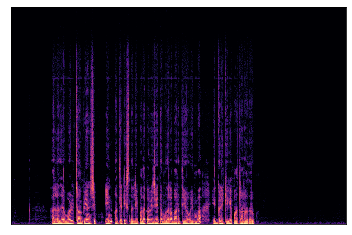

In [11]:
y,x=get_spectrogram('Dataset/Kannada/knm_00180_00012816557.wav')

plt.savefig('example.png')

## Iterate over all the files to get spectrograms for all the files

In [55]:
for i in range(len(filenames)):
    y, label=get_spectrogram(filenames[i])
    plt.savefig('Spectrograms/'+'/'+str(label)+'/'+str(i)+'.png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

## Image pre processing

In [23]:
batch_size = 64
img_height = 256
img_width = 256

data_dir='Spectrograms'

In [24]:
#train dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6324 files belonging to 3 classes.
Using 5060 files for training.


In [25]:
# test dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6324 files belonging to 3 classes.
Using 1264 files for validation.


In [26]:
# model define

num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 128)     3584      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 256, 128)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      73792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 64)       

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/10
 3/80 [>.............................] - ETA: 16:52 - loss: 4.5573 - accuracy: 0.4062